In [2]:
import argparse
import json
import math
import os
import random
from time import time

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup

from dataset import (
    collate_fn,
    TURLColTypeColwiseDataset,
    TURLColTypeTablewiseDataset,
    TURLRelExtColwiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVColwiseDataset,
    SatoCVTablewiseDataset,
)

from model import BertForMultiOutputClassification, BertMultiPairPooler
from util import f1_score_multilabel


In [3]:
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=128,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--batch_size",
        default=32,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=30,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    #TOCHECK
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    #TODO
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--tasks",
                        type=str,
                        nargs="+",
                        default=["sato0"],
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "turl", "turl-re"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--train_ratios",
                        type=str,
                        nargs="+",
                        default=[],
                        help="e.g., --train_ratios turl=0.8 turl-re=0.1")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--single_col",
                        default=False,
                        action="store_true",
                        help="Training with single column model")

    args = parser.parse_args([])
    args.tasks = sorted(args.tasks)

    task_num_class_dict = {
        "sato0": 78,
        "sato1": 78,
        "sato2": 78,
        "sato3": 78,
        "sato4": 78,
        "msato0": 78,
        "msato1": 78,
        "msato2": 78,
        "msato3": 78,
        "msato4": 78,
        "turl": 255,
        "turl-re": 121
    }

    train_ratio_dict = {}
    num_classes_list = []
    for task in args.tasks:
        num_classes_list.append(task_num_class_dict[task])
        # Default training ratio is ALL
        train_ratio_dict[task] = 1.0

    # Training ratio
    for train_ratio in args.train_ratios:
        task, ratio_str = train_ratio.split("=")
        ratio = float(ratio_str)
        assert task in train_ratio_dict, "Invalid task name: {}".format(task)
        assert 0 < ratio <= 1
        train_ratio_dict[task] = ratio

    # For tagname
    train_ratio_str_list = []
    for task in sorted(train_ratio_dict.keys()):
        ratio = train_ratio_dict[task]
        train_ratio_str_list.append("{}-{:.2f}".format(task, ratio))

In [4]:
device = torch.device('cpu')

In [4]:
    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

In [8]:
shortcut_name 

'bert-base-uncased'

In [5]:
dataset_cls = SatoCVColwiseDataset

In [6]:
train_ratio_dict[task]

1.0

In [16]:
cv = int(task[-1])
multicol_only = False
tokenizer = BertTokenizer.from_pretrained(shortcut_name)
train_ratio = train_ratio_dict[task]
train_dataset = dataset_cls(cv=cv,
                                        split="train",
                                        tokenizer=tokenizer,
                                        max_length=max_length,
                                        multicol_only=True,
                                        train_ratio=train_ratio,
                                        device=device,
                                        base_dirpath="/data/zhihao/TU/doduo/data",)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
cv = int(task[-1])
multicol_only = False
tokenizer = BertTokenizer.from_pretrained(shortcut_name)
train_ratio = train_ratio_dict[task]
train_dataset_single = dataset_cls(cv=cv,
                                        split="train",
                                        tokenizer=tokenizer,
                                        max_length=max_length,
                                        multicol_only=False,
                                        train_ratio=train_ratio,
                                        device=device,
                                        base_dirpath="/data/zhihao/TU/doduo/data",)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [86]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [45]:
train_dataset_single[0]

{'data': tensor([  101, 17765, 22818,  2177,  6207, 10598,  6373,   102]),
 'label': tensor([19])}

In [46]:
length_single = []
for i in range(len(train_dataset_single)):
    length_single.append(len(train_dataset_single[i]['data']))

In [47]:
max(length_single)

130

In [20]:
len(train_dataset)

46502

In [23]:
len(train_dataset_single)

76293

In [24]:
base_dirpath = "/data/zhihao/TU/doduo/data"
basename = "sato_cv_{}.csv"
filepath = os.path.join(base_dirpath, basename.format(0))
df = pd.read_csv(filepath)

In [25]:
df

,table_id,col_idx,class,class_id,data
0,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,name,46,Cleanliness Structural
1,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,rank,60,1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
2,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,city,12,"Wiesbaden, DE Oldenburg, DE Saarbrücken, DE Fr..."
3,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,1,rank,60,368 1049 156 1827 859 9999 162 869 15 8
4,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,year,77,2006 2006 2006 2006
...,...,...,...,...,...
23815,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,1,location,44,Work at Home Work at Home Work at Home
23816,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,0,team,73,18. Scunthorpe 19. Sheff Utd 20. Shrewsbury 21...
23817,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,0,rank,60,1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 ...
23818,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,1,name,46,R. Abbott B. Herzog J. True R. M C. Crawford j...


In [31]:
df.loc[[1], ['data']].values[0][0]

'1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0'

In [38]:
df['class'].unique()

array(['name', 'rank', 'city', 'year', 'status', 'age', 'club', 'class',
       'team', 'result', 'company', 'symbol', 'artist', 'location',
       'notes', 'weight', 'type', 'day', 'state', 'description',
       'address', 'category', 'position', 'person', 'code', 'plays',
       'gender', 'service', 'album', 'duration', 'format', 'area',
       'range', 'elevation', 'currency', 'credit', 'depth', 'fileSize',
       'component', 'country', 'county', 'industry', 'product',
       'teamName', 'birthDate', 'sex', 'jockey', 'owner', 'publisher',
       'language', 'nationality', 'affiliation', 'origin', 'creator',
       'order', 'affiliate', 'collection', 'family', 'capacity',
       'classification', 'grades', 'birthPlace', 'requirement', 'species',
       'ranking', 'region', 'isbn', 'genre', 'brand', 'religion',
       'manufacturer', 'continent', 'command', 'sales', 'operator',
       'education', 'director', 'organisation'], dtype=object)

In [128]:
df

,table_id,col_idx,class,class_id,data
0,webtables1/K1_multi-col/0_1438042986022.41;war...,0,name,46,Nicholas J Brunelli Kevin Doak Scott C Greenwo...
1,webtables1/K1_multi-col/0_1438042986022.41;war...,1,age,3,30 30 34 30 30 30 31 32 33 34
2,webtables1/K1_multi-col/0_1438042986022.41;war...,2,club,15,NCMS MICH TOC UNAT CAT SCMC TOC SCSC MGM SKY
3,webtables1/K1_multi-col/0_1438042986022.41;war...,1,format,36,Adobe PDF Microsoft Powerpoint
4,webtables1/K1_multi-col/0_1438042986022.41;war...,0,name,46,Colombian Soul (Patric la Funk New School Remi...
...,...,...,...,...,...
14722,webtables2/K4_multi-col/0_1438042987171.38;war...,0,age,3,0/3M 3/6M 6/9M
14723,webtables2/K4_multi-col/0_1438042987171.38;war...,1,weight,76,up to 12 lbs 12-17 lbs 17-20 lbs
14724,webtables2/K4_multi-col/0_1438042987171.38;war...,2,weight,76,up to 5.4 kgs 5.4-7.7 kgs 7.7-9.1 kgs
14725,webtables2/K4_multi-col/0_1438042987171.38;war...,0,name,46,Salih Metin Ecevit Ibrahim Yazici S. Kamil Yaz...


In [40]:
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    break

In [127]:
df["class"]

0          name
1           age
2          club
3        format
4          name
          ...  
14722       age
14723    weight
14724    weight
14725      name
14726       age
Name: class, Length: 58357, dtype: object

In [41]:
group_df

,table_id,col_idx,class,class_id,data
3400,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,country,22,United States — Alabama — Alaska — Arizona — A...


<Axes: ylabel='Count'>

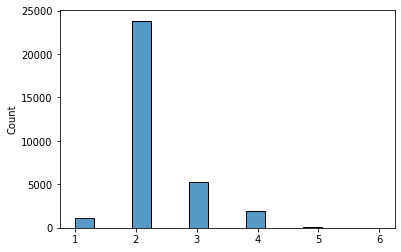

In [137]:
base_dirpath = "/data/zhihao/TU/doduo/data"
basename = "msato_cv_{}.csv"
df_list = []
for i in range(5):
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df = pd.concat(df_list, axis=0)
df_group = df.groupby("table_id")
column_num = []
for i, (index, group_df) in enumerate(df_group):
    column_num.append(len(group_df))
sns.histplot(column_num)

In [138]:
df

,table_id,col_idx,class,class_id,data
0,webtables1/K0_multi-col/0_1438042986022.41;war...,0,city,12,Vancouver Victoria Edmonton Urbana Toronto Ottawa
1,webtables1/K0_multi-col/0_1438042986022.41;war...,1,state,70,BC BC AB IL ON ON
2,webtables1/K0_multi-col/0_1438042986022.41;war...,0,type,75,Windows account Service account
3,webtables1/K0_multi-col/0_1438042986022.41;war...,1,description,29,You must log on to the Web server computer wit...
4,webtables1/K0_multi-col/0_1438042986022.41;war...,0,name,46,Name ArkInventory-r38734-nolib ArkInventory-r3...
...,...,...,...,...,...
14722,webtables2/K4_multi-col/0_1438042987171.38;war...,0,age,3,0/3M 3/6M 6/9M
14723,webtables2/K4_multi-col/0_1438042987171.38;war...,1,weight,76,up to 12 lbs 12-17 lbs 17-20 lbs
14724,webtables2/K4_multi-col/0_1438042987171.38;war...,2,weight,76,up to 5.4 kgs 5.4-7.7 kgs 7.7-9.1 kgs
14725,webtables2/K4_multi-col/0_1438042987171.38;war...,0,name,46,Salih Metin Ecevit Ibrahim Yazici S. Kamil Yaz...


In [18]:
base_dirpath = "/data/zhihao/TU/doduo/data"
basename = "sato_cv_{}.csv"
df_list = []

filepath = os.path.join(base_dirpath, basename.format(0))
df_test = pd.read_csv(filepath)

df_group_test = df_test.groupby("table_id")

In [40]:
cv = 0
df_list = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_train = pd.concat(df_list, axis=0)
df_group_train = df_train.groupby("table_id")

In [19]:
len(df_test)

23820

<Axes: ylabel='Count'>

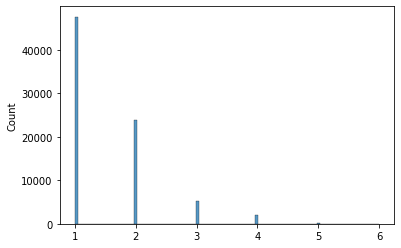

In [140]:
base_dirpath = "/data/zhihao/TU/doduo/data"
basename = "sato_cv_{}.csv"
df_list = []
for i in range(5):
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df = pd.concat(df_list, axis=0)
df_group = df.groupby("table_id")
column_num = []
for i, (index, group_df) in enumerate(df_group):
    column_num.append(len(group_df))
sns.histplot(column_num)

In [150]:
# calculate frequency of each class
df["class_id"].value_counts().sort_index()

0       841
1        26
2       198
3      7179
4      1525
      ...  
73    10373
74      243
75     6625
76     3093
77     5349
Name: class_id, Length: 78, dtype: int64

In [94]:
class_count.min()

15

<Axes: >

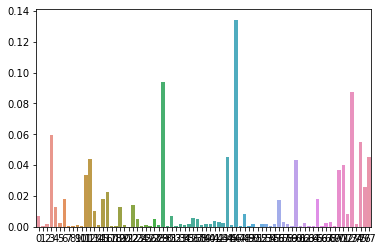

In [92]:
import seaborn as sns
class_count = df_train["class_id"].value_counts().sort_index().values
class_freq = class_count/len(df_train)
sns.barplot(x=np.arange(len(class_freq)), y=class_freq)

In [132]:
df

,table_id,col_idx,class,class_id,data
0,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,name,46,Cleanliness Structural
1,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,rank,60,1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
2,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,city,12,"Wiesbaden, DE Oldenburg, DE Saarbrücken, DE Fr..."
3,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,1,rank,60,368 1049 156 1827 859 9999 162 869 15 8
4,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,year,77,2006 2006 2006 2006
...,...,...,...,...,...
23982,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,1,location,44,Queenstown Alexandra Dunedin Dunedin
23983,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,0,team,73,Hamilton Bulldogs Wilkes-Barre/Scranton Pengui...
23984,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,0,code,16,FEEDME10 JYCNMEVP WEBSAVER BARROWIF LOVEDOM! Y...
23985,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,0,year,77,2003/04 2004/05 2005/06 2006/07 2007/08 2007/0...


In [122]:
df_group = df.groupby("table_id")
column_num = []
for i, (index, group_df) in enumerate(df_group):
    column_num.append(len(group_df))

6


<Axes: ylabel='Count'>

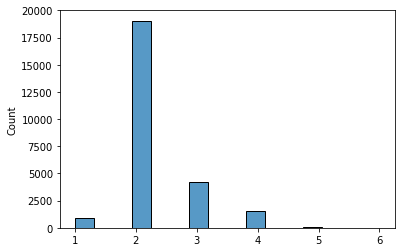

In [125]:
print(max(column_num))
sns.histplot(column_num)

In [121]:
len(group_df)

3

In [63]:
df_multi.loc[[0],["table_id"]].values[0][0]

'webtables1/K0_multi-col/0_1438042986022.41;warc;CC-MAIN-20150728002306-00023-ip-10-236-191-2.ec2.internal.json.gz_2381-Plants And Animals Concer_M7FH7H67JKDBEZRS'

In [67]:
table_names = [title.split("-")[-1] for title in df_multi["table_id"].values]

In [69]:
table_names[:10]

['Plants And Animals Concer_M7FH7H67JKDBEZRS',
 'Plants And Animals Concer_M7FH7H67JKDBEZRS',
 'Web Application Requireme_VOUQM65YXY2ZSPSI',
 'Web Application Requireme_VOUQM65YXY2ZSPSI',
 ' Wo_BKQQVUXKM2LUBSWG',
 ' Wo_BKQQVUXKM2LUBSWG',
 '1997 USMS Top 10 SCM for _RLWYTTQLR645ACFV',
 '1997 USMS Top 10 SCM for _RLWYTTQLR645ACFV',
 '1997 USMS Top 10 SCM for _RLWYTTQLR645ACFV',
 '_E3IERQO3AJUBAC5B']

In [59]:
df_multi

,table_id,col_idx,class,class_id,data
0,webtables1/K0_multi-col/0_1438042986022.41;war...,0,city,12,Vancouver Victoria Edmonton Urbana Toronto Ottawa
1,webtables1/K0_multi-col/0_1438042986022.41;war...,1,state,70,BC BC AB IL ON ON
2,webtables1/K0_multi-col/0_1438042986022.41;war...,0,type,75,Windows account Service account
3,webtables1/K0_multi-col/0_1438042986022.41;war...,1,description,29,You must log on to the Web server computer wit...
4,webtables1/K0_multi-col/0_1438042986022.41;war...,0,name,46,Name ArkInventory-r38734-nolib ArkInventory-r3...
...,...,...,...,...,...
14530,webtables2/K0_multi-col/0_1438042987171.38;war...,0,name,46,Alison Terry Kerry Fraas Heather Hageman Franc...
14531,webtables2/K0_multi-col/0_1438042987171.38;war...,1,age,3,25 25 29 27 27 27 29 26 28 29
14532,webtables2/K0_multi-col/0_1438042987171.38;war...,2,club,15,SDSM NCMS NCMS OREG CHMS RMM GERM NIAG WPM ORLM
14533,webtables2/K0_multi-col/0_1438042987171.38;war...,0,position,56,131 – 131 162 – 162 162 – 162 165 – 165 169 – ...


In [51]:
for i, (index, group_df) in enumerate(df_multi.groupby("table_id")):
    break

In [44]:
group_df

,table_id,col_idx,class,class_id,data
347,webtables1/K0_multi-col/0_1438042986022.41;war...,0,code,16,VISR VIAW OPSD FR3254
348,webtables1/K0_multi-col/0_1438042986022.41;war...,1,name,46,SRINAGAR AWANTIPUR SKARDU KARGIL
349,webtables1/K0_multi-col/0_1438042986022.41;war...,2,city,12,Srinagar Skardu


In [52]:
token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                x, add_special_tokens=True, max_length=max_length + 2)).tolist(
                )

In [56]:
from functools import reduce
import operator
import os
import pickle

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import transformers
token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)

In [57]:
token_ids

tensor([  101, 25292,  2099,  3081,  2860, 23092,  2094, 10424, 16703, 27009,
          102,   101,  5185, 14346, 22091,  4630, 11514,  3126, 24053,  4103,
         2226, 10556, 10623,  4014,   102,   101,  5185, 14346, 24053,  4103,
         2226,   102])

In [70]:
dataset_cls = SatoCVTablewiseDataset

In [112]:
max_length

128

In [115]:
dataset_list = [dataset_cls(cv=i,
                                        split="test",
                                        tokenizer=tokenizer,
                                        max_length=32,
                                        multicol_only=True,
                                        train_ratio=train_ratio,
                                        device=device,
                                        base_dirpath="/data/zhihao/TU/doduo/data",) for i in range(1)]

In [116]:
length_list = []
for i in range(1):
    length = []
    for j in range(len(dataset_list[i])):
        length.append(len(dataset_list[i][j]['data']))
    length_list.append(length)

In [ ]:
length_list = []
for i in range(5):
    length = []
    for j in range(len(dataset_list[i])):
        length.append(len(dataset_list[i][j]['data']))
    length_list.append(length)

In [ ]:
for i in range(5):
    print(len(length_list[i]))

6451
6516
6431
6374
6493


<Axes: ylabel='Count'>

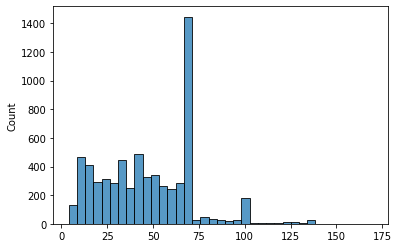

In [117]:
import seaborn as sns
sns.histplot(length_list[0])

<Axes: ylabel='Count'>

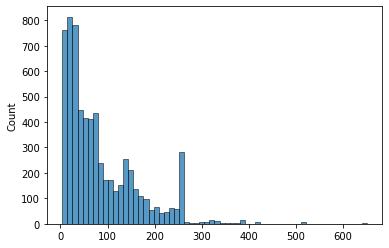

In [ ]:
import seaborn as sns
sns.histplot(length_list[0])

In [ ]:
for i in range(5):
    print(max(length_list[i]))
    

In [104]:
len(dataset_list[0][0]['data'])

32

In [102]:
train_dataset = dataset_cls(cv=4,
                                        split="test",
                                        tokenizer=tokenizer,
                                        max_length=max_length,
                                        multicol_only=True,
                                        train_ratio=train_ratio,
                                        device=device,
                                        base_dirpath="/data/zhihao/TU/doduo/data",)

In [72]:
sato_coltypes = ["address", "affiliate", "affiliation", "age", "album", "area",
                 "artist", "birthDate", "birthPlace", "brand", "capacity", "category",
                 "city", "class", "classification", "club", "code", "collection", "command",
                 "company", "component", "continent", "country", "county", "creator", "credit",
                 "currency", "day", "depth", "description", "director", "duration", "education",
                 "elevation", "family", "fileSize", "format", "gender", "genre", "grades", "isbn",
                 "industry", "jockey", "language", "location", "manufacturer", "name", "nationality",
                 "notes", "operator", "order", "organisation", "origin", "owner", "person", "plays",
                 "position", "product", "publisher", "range", "rank", "ranking", "region", "religion",
                 "requirement", "result", "sales", "service", "sex", "species", "state", "status",
                 "symbol", "team", "teamName", "type", "weight", "year"]

In [73]:
len(sato_coltypes)

78

In [76]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
with open("/data/zhihao/TU/doduo/eval/msato0_mosato_bert_bert-base-uncased-bs16-ml-32__msato0-1.00=msato0.json", 'r') as f:
    data = json.load(f)

In [78]:
data.keys()

dict_keys(['f1_macro', 'f1_micro'])

In [80]:
data['f1_micro'].keys()

dict_keys(['ts_micro_f1', 'ts_macro_f1', 'ts_class_f1', 'confusion_matrix'])

In [84]:
len(data['f1_micro']['ts_class_f1'])

78

In [96]:
# data['f1_micro']['ts_class_f1']

In [82]:
len(data['f1_micro']['confusion_matrix'])

78

In [91]:
table_lens = torch.Tensor([len(train_dataset[i]["data"]) for i in range(len(train_dataset))])

In [93]:
table_lens.min()

tensor(3.)

In [94]:
table_lens.mean()

tensor(87.1377)

In [95]:
table_lens.max()

tensor(650.)

In [97]:

test_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                collate_fn=collate_fn)

In [100]:
length = []
for data in test_dataloader:
    length.append(data["data"].T.shape[1])

In [101]:
max(length)

650

In [5]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
    results = json.load(f)

In [6]:
results["loss"].keys()

dict_keys(['ts_micro_f1', 'ts_macro_f1', 'ts_class_f1', 'confusion_matrix', 'true_list', 'pred_list'])

In [9]:
labels = np.array(results["loss"]['true_list'])
preds = np.array(results["loss"]['pred_list'])

In [11]:
labels.shape

(23820,)

In [ ]:
labels

In [180]:
cfm = np.array(results["loss"]["confusion_matrix"])

In [76]:
class_f1 = np.array(results["loss"]['ts_class_f1'])

<Axes: >

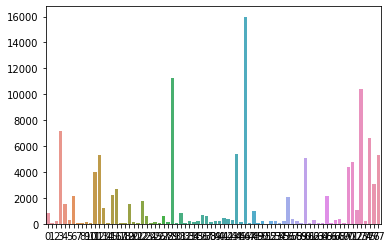

In [166]:
class_samples = df["class_id"].value_counts().sort_index().values
sns.barplot(x=np.arange(len(class_samples)), y=class_samples)

In [163]:
class_freq

array([0.00704591, 0.00021783, 0.00165885, 0.06014578, 0.01277647,
       0.00237098, 0.01807976, 0.00054457, 0.00045241, 0.00116454,
       0.00046079, 0.03352044, 0.04436997, 0.0101374 , 0.00082942,
       0.0183311 , 0.02261227, 0.00073727, 0.00067862, 0.01274296,
       0.00142426, 0.00020945, 0.01443532, 0.00502681, 0.00032674,
       0.00115617, 0.00058646, 0.00492627, 0.00112265, 0.09431133,
       0.00027647, 0.00670241, 0.00030161, 0.00168398, 0.00113941,
       0.00184316, 0.00549598, 0.0047252 , 0.00134048, 0.00183479,
       0.00191019, 0.00352714, 0.00294068, 0.00256367, 0.04491454,
       0.00127346, 0.13397286, 0.00061997, 0.00845342, 0.00032674,
       0.00174263, 0.00017594, 0.00172587, 0.00157507, 0.00030161,
       0.00175101, 0.01740952, 0.00310824, 0.00181803, 0.00056971,
       0.04285355, 0.00046079, 0.00272286, 0.00031836, 0.00029323,
       0.01792058, 0.00025134, 0.00233747, 0.0032004 , 0.00067862,
       0.03672084, 0.03997151, 0.00867125, 0.08690516, 0.00203

In [165]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(class_freq, class_f1)
print(f'Correlation: {correlation}, p-value: {p_value}')


Correlation: 0.32802076344339465, p-value: 0.0033699307331212427


In [101]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(class_freq, class_col_num)
print(f'Correlation: {correlation}, p-value: {p_value}')


Correlation: 0.052233820617254983, p-value: 0.6497000909761631


In [102]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr( class_col_num, class_f1)
print(f'Correlation: {correlation}, p-value: {p_value}')


Correlation: 0.2502914581324852, p-value: 0.027096000235150547


In [167]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(class_samples, class_f1)
print(f'Correlation: {correlation}, p-value: {p_value}')

Correlation: 0.32802076344339465, p-value: 0.0033699307331212427


In [104]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(class_col_num/np.linalg.norm(class_col_num), class_f1)
print(f'Correlation: {correlation}, p-value: {p_value}')

Correlation: 0.2502914581324852, p-value: 0.027096000235150547


In [105]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr((class_col_num/np.linalg.norm(class_col_num))*(class_freq/np.linalg.norm(class_freq)), class_f1)
print(f'Correlation: {correlation}, p-value: {p_value}')

Correlation: 0.34319679689402677, p-value: 0.0020972637758838327


In [103]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(class_freq/np.linalg.norm(class_freq), class_f1)
print(f'Correlation: {correlation}, p-value: {p_value}')

Correlation: 0.3275072706216619, p-value: 0.0034230477611550073


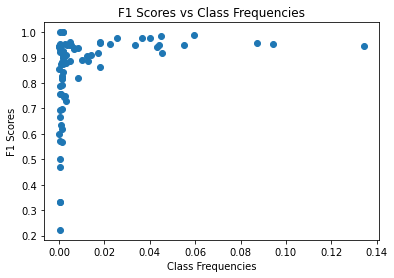

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_f1 and class_frequencies are your actual data
plt.scatter(class_freq, class_f1)
plt.xlabel('Class Frequencies')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Class Frequencies')
plt.show()


In [170]:
(class_freq<0.01).sum()

56

In [172]:
class_freq[class_f1<0.8]

array([0.00021783, 0.00237098, 0.00116454, 0.00046079, 0.00082942,
       0.00067862, 0.00142426, 0.00032674, 0.00027647, 0.00134048,
       0.00127346, 0.00061997, 0.00032674, 0.00030161, 0.00310824,
       0.00056971, 0.00046079, 0.00272286, 0.00029323, 0.00067862])

In [174]:
max(class_freq[class_f1<0.8])

0.0031082439678284182

In [12]:
sato_coltypes = np.array(["address", "affiliate", "affiliation", "age", "album", "area",
                 "artist", "birthDate", "birthPlace", "brand", "capacity", "category",
                 "city", "class", "classification", "club", "code", "collection", "command",
                 "company", "component", "continent", "country", "county", "creator", "credit",
                 "currency", "day", "depth", "description", "director", "duration", "education",
                 "elevation", "family", "fileSize", "format", "gender", "genre", "grades", "isbn",
                 "industry", "jockey", "language", "location", "manufacturer", "name", "nationality",
                 "notes", "operator", "order", "organisation", "origin", "owner", "person", "plays",
                 "position", "product", "publisher", "range", "rank", "ranking", "region", "religion",
                 "requirement", "result", "sales", "service", "sex", "species", "state", "status",
                 "symbol", "team", "teamName", "type", "weight", "year"])
numeric_keywords = [
    "age", "year", "capacity", "code", "rank", "ranking", "sales", "duration", 
    "elevation", "fileSize", "grades", "isbn", "order", "range", "depth", "weight"
]
is_numeric = np.array([coltype in numeric_keywords for coltype in sato_coltypes])

In [ ]:
cfm = np.array(results["loss"]["confusion_matrix"])

In [13]:
(labels==1).sum()

5

In [15]:
preds_affiliate = preds[labels==1]

In [17]:
sato_coltypes[preds_affiliate]

array(['status', 'affiliate', 'affiliate', 'affiliate', 'status'],
      dtype='<U14')

In [25]:
preds[labels==1]

array([71,  1,  1,  1, 71])

In [29]:
np.nonzero(labels==1)

(array([ 6940,  9013, 11357, 11764, 18385]),)

In [28]:
preds.shape

(23820,)

In [27]:
df_test

,table_id,col_idx,class,class_id,data
0,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,name,46,Cleanliness Structural
1,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,rank,60,1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
2,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,city,12,"Wiesbaden, DE Oldenburg, DE Saarbrücken, DE Fr..."
3,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,1,rank,60,368 1049 156 1827 859 9999 162 869 15 8
4,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,year,77,2006 2006 2006 2006
...,...,...,...,...,...
23815,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,1,location,44,Work at Home Work at Home Work at Home
23816,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,0,team,73,18. Scunthorpe 19. Sheff Utd 20. Shrewsbury 21...
23817,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,0,rank,60,1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 ...
23818,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,1,name,46,R. Abbott B. Herzog J. True R. M C. Crawford j...


In [226]:
is_numeric.sum()

16

In [178]:
sato_coltypes[class_f1<0.8]

array(['affiliate', 'area', 'brand', 'capacity', 'classification',
       'command', 'component', 'creator', 'director', 'genre',
       'manufacturer', 'nationality', 'operator', 'person', 'product',
       'range', 'ranking', 'region', 'requirement', 'species'],
      dtype='<U14')

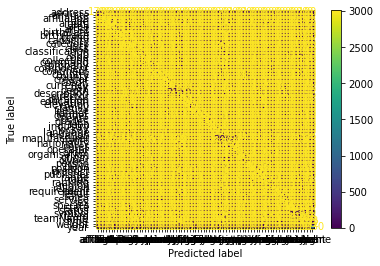

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cfm, display_labels=sato_coltypes)
disp.plot()

In [187]:
np.nonzero(class_f1<0.8)

(array([ 1,  5,  9, 10, 14, 18, 20, 24, 30, 38, 45, 47, 49, 54, 57, 59, 61,
        62, 64, 69]),)

In [191]:
cfm[i][j]

11

In [229]:
class_f1[is_numeric]

array([0.98890756, 0.69230769, 0.95483871, 0.82051282, 0.93515358,
       0.91262136, 0.90566038, 1.        , 1.        , 0.84337349,
       0.47058824, 0.94265594, 0.22222222, 0.94117647, 0.97721917,
       0.98470363])

In [44]:
group_df["class_id"].values

array([46])

In [45]:
group_df

,table_id,col_idx,class,class_id,data
11947,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,0,name,46,Holly Zinnecker Abbie Goetsch Jannelle Schrode...


In [58]:
column_cooccur = np.zeros((len(sato_coltypes), len(sato_coltypes)))
for i, (index, group_df) in enumerate(df_group_train):
    coltypes = group_df["class_id"].values
    for i in range(len(coltypes)):
        column_cooccur[coltypes[i],coltypes[i]] += 1 # self count
    if len(coltypes) > 1:
        for i in range(len(coltypes)-1):
            column_cooccur[coltypes[i],coltypes[i+1]] += 1
            column_cooccur[coltypes[i+1],coltypes[i]] += 1

In [52]:
np.nonzero(column_cooccur[1]>0)

(array([ 1, 60, 75]),)

In [50]:
sato_coltypes[column_cooccur[1]>0]

array(['affiliate', 'rank', 'type'], dtype='<U14')

In [60]:
order_index = np.argsort(column_cooccur[75])[::-1]

In [71]:
np.nonzero(column_cooccur[75])

(array([ 0,  1,  3,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22,
        23, 26, 27, 29, 31, 33, 35, 36, 38, 39, 43, 44, 45, 46, 48, 49, 50,
        52, 53, 56, 57, 58, 59, 60, 62, 65, 66, 67, 70, 71, 72, 73, 75, 76,
        77]),)

In [72]:
for i in np.nonzero(column_cooccur[75])[0]:
    if sato_coltypes[i] in ["affiliate", "status"]:
        print(sato_coltypes[i], column_cooccur[75][i])

affiliate 6.0
status 76.0


In [67]:
sato_coltypes[order_index[:520]]

array(['type', 'name', 'year', 'description', 'class', 'location',
       'elevation', 'status', 'country', 'result', 'grades', 'owner',
       'team', 'company', 'notes', 'component', 'city', 'position',
       'category', 'operator', 'sales', 'state', 'code', 'area',
       'address', 'origin', 'affiliate', 'weight', 'manufacturer',
       'format', 'range', 'age', 'brand', 'order', 'artist', 'publisher',
       'rank', 'fileSize', 'duration', 'language', 'region', 'product',
       'command', 'service', 'symbol', 'club', 'classification', 'day',
       'capacity', 'county', 'currency', 'genre', 'species', 'person',
       'affiliation', 'plays', 'album', 'teamName', 'nationality',
       'birthDate', 'birthPlace', 'jockey', 'industry', 'isbn',
       'organisation', 'credit', 'gender', 'family', 'education',
       'collection', 'director', 'requirement', 'religion', 'continent',
       'ranking', 'depth', 'creator', 'sex'], dtype='<U14')

In [69]:
df_train[df_train["class"] == 'affiliate']

,table_id,col_idx,class,class_id,data
5191,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,WPBT WFOR WTVJ WSVN WGEN WPLG WLRN WSBS WLTV W...
8594,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,"Sonnenschein, Nath & Rosenthal Sonnenschein, N..."
8657,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,Alabama Rural Electric Assn Idaho ACRE Indiana...
22813,webtables2/K1/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,Plumbers/Pipefitters Union National Rifle Assn
4104,webtables1/K2/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,League of Conservation Voters National Educati...
12820,webtables2/K2/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,WHAM WROC CW WUHF WHEC WXXI
15206,webtables2/K2/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,National Rifle Assn
18314,webtables2/K2/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,Incapital LLC
20522,webtables2/K2/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,Steny H. Hoyer (D-Md) Patrick Leahy (D-Vt)
21877,webtables2/K2/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,Brett Guthrie (R-Ky) Jim DeMint (R-SC) Greg Wa...


In [70]:
df_train[df_train["class"] == 'affiliation']

,table_id,col_idx,class,class_id,data
1326,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,1,affiliation,2,OSCE/ODIHR Tolerance Unit Migrant Women's Netw...
1770,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,1,affiliation,2,Commission on Security and Cooperation in Euro...
1786,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,1,affiliation,2,U.S. Commission on Security and Cooperation in...
1886,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,1,affiliation,2,Helsinki Commission Helsinki Commission Helsin...
2809,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,1,affiliation,2,Department of State Department of State Depart...
...,...,...,...,...,...
20062,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,1,affiliation,2,U.S. Commission on Security and Cooperation in...
21342,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,1,affiliation,2,The Helsinki Commission The Helsinki Commissio...
21845,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,1,affiliation,2,Commission on Security and Cooperation in Euro...
23645,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,1,affiliation,2,Commission on Security and Cooperation in Euro...


In [66]:
len(sato_coltypes[column_cooccur[75]>0])

52

In [90]:
group_df

,table_id,col_idx,class,class_id,data
8900,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,0,company,19,Goldman Sachs Group Apple Walt Disney


In [91]:
class_freq

array([0.0068139 , 0.0002198 , 0.00165376, 0.05954574, 0.01295792,
       0.00238644, 0.0182646 , 0.00056521, 0.00040821, 0.00115135,
       0.00043961, 0.03362989, 0.04421185, 0.01015282, 0.00086875,
       0.01818087, 0.02253506, 0.00073268, 0.00073268, 0.01256018,
       0.00141302, 0.000157  , 0.01433954, 0.00492987, 0.000314  ,
       0.00119322, 0.00055474, 0.00483567, 0.00122462, 0.09414905,
       0.00030354, 0.00685577, 0.00027214, 0.00158049, 0.00118275,
       0.00175843, 0.00552648, 0.00475194, 0.00136069, 0.00188403,
       0.00197823, 0.00344358, 0.00290978, 0.00256437, 0.04546787,
       0.00124555, 0.13424744, 0.00058614, 0.00850952, 0.00034541,
       0.00169562, 0.0001884 , 0.00167469, 0.00154909, 0.00030354,
       0.00169562, 0.01737492, 0.00309818, 0.00180029, 0.00062801,
       0.04332217, 0.00045007, 0.00267951, 0.00033494, 0.0002826 ,
       0.01803433, 0.00023027, 0.0023969 , 0.00332845, 0.00068034,
       0.03660247, 0.03998325, 0.00857233, 0.08714674, 0.00197

In [95]:
class_col_num = np.zeros(len(sato_coltypes))
for i, (index, group_df) in enumerate(df_group_train):
    col_num = len(group_df)
    coltypes = group_df["class_id"].values
    for coltype in coltypes:
        class_col_num[coltype] += col_num
class_col_num = class_col_num/class_count

In [84]:
count = 0
dfgroup_list = []
column_length_test = []
for i, (index, group_df) in enumerate(df_group_test):
    if True in (group_df["class"] == 'affiliate').values:
        print(group_df[['class', 'data']])
        count += 1
        dfgroup_list.append(group_df[["col_idx", 'class', 'data']])
    column_length_test += [len(group_df)] * len(group_df)
dfgroup_list = pd.concat(dfgroup_list, axis=0)
column_length_test = np.array(column_length_test)
print(np.unique(column_length_test))
    # if count > 5:
    #     break

          class                              data
2979  affiliate       Right to Life Right to Life
2980       type  IE IE IE IE IE CC IE IE IE CC IE
          class                                               data
8810  affiliate  Harry Reid (D-Nev) Tom Udall (D-NM) Mark Udall...
         class                                       data
773  affiliate  Republican Party of Indiana Right to Life
774       type                                IE IE CC IE
          class                       data
5427  affiliate  Charles E. Schumer (D-NY)
           class               data
23569  affiliate      Right to Life
23570       type  IE IE IE CC IE IE
[1 2 3 4 5]


In [86]:
preds

array([22, 46, 46, ..., 60, 60, 46])

In [88]:
for i in np.unique(column_length_test):
    mask = column_length_test==i
    acc = (preds[mask] == labels[mask]).sum()/mask.sum()
    cl_freq = class_freq[labels[mask]].mean()
    print(i, acc, cl_freq)

1 0.9170613619618988 0.06141599805597626
2 0.9579331941544885 0.05362387754825554
3 0.9690656565656566 0.0545419854289176
4 0.9685828877005348 0.04748512256254624
5 0.9333333333333333 0.0486450352382946


In [82]:
len(class_f1)

78

In [83]:
len(column_length_test)

23820

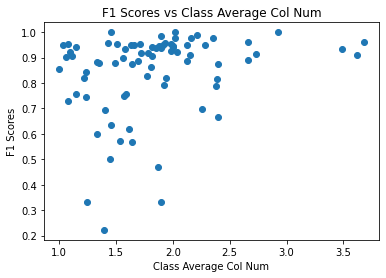

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_f1 and class_frequencies are your actual data
plt.scatter(class_col_num, class_f1)
plt.xlabel('Class Average Col Num')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Class Average Col Num')
plt.show()

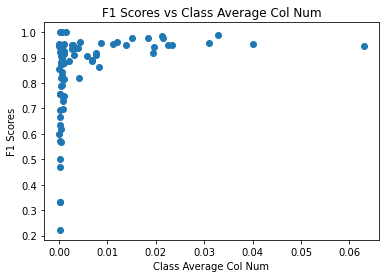

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_f1 and class_frequencies are your actual data
plt.scatter((class_col_num/np.linalg.norm(class_col_num))*(class_freq/np.linalg.norm(class_freq)), class_f1)
plt.xlabel('Class Average Col Num')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Class Average Col Num')
plt.show()

In [235]:
dfgroup_list

,col_idx,class,data
2979,0,affiliate,Right to Life Right to Life
2980,1,type,IE IE IE IE IE CC IE IE IE CC IE
8810,0,affiliate,Harry Reid (D-Nev) Tom Udall (D-NM) Mark Udall...
773,0,affiliate,Republican Party of Indiana Right to Life
774,1,type,IE IE CC IE
5427,0,affiliate,Charles E. Schumer (D-NY)
23569,0,affiliate,Right to Life
23570,1,type,IE IE IE CC IE IE


In [224]:
count = 0
for i, (index, group_df) in enumerate(df_group_test):
    if True in (group_df["class"] == 'status').values:
        print(group_df[['class', 'data']])
        count += 1
    if count > 5:
        break

       class                                          data
6204  status  Answered Answered Answered Answered Answered
         class                                               data
4078       day  Monday Wednesday Thursday Friday Saturday Sund...
4079  location  Away Home Away Away Home Home Home Away Home H...
4080    status  Final Final Final Final Postponed: May 29th Po...
4081    result             Win Win Win Loss Win Win Loss Loss Win
       class                                               data
1105  status  ENROUTE ONSCENE ENROUTE ONSCENE ONSCENE ONSCEN...
       class                                               data
6615    type  TV TV TV OVA OVA OVA TV Movie TV Movie TV TV T...
6616    year  2011 1973 1997 1990 1998 1989 1998 1999 1968 1...
6617  status  Stalled Want to Watch Stalled Stalled Want to ...
       class                 data
2470  status  confirmed confirmed
         class                                               data
7189  location                    

In [207]:
group_df

,table_id,col_idx,class,class_id,data
6204,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,status,71,Answered Answered Answered Answered Answered


In [199]:
group_df

,table_id,col_idx,class,class_id,data
3400,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,country,22,United States — Alabama — Alaska — Arizona — A...


In [196]:
df[df['class'] == 'status']

,table_id,col_idx,class,class_id,data
5,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,status,71,WIP OK WIP OK WIP WIP WIP OK... OK WIP WIP WIP...
28,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,2,status,71,Final Final/11 Final Final Final Final Final F...
78,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,status,71,TO DO TO DO TO DO TO DO TO DO IN PROGRESS IN P...
83,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,1,status,71,lead lead
87,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,2,status,71,Unavailable Unavailable
...,...,...,...,...,...
23700,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,0,status,71,WAITING ONSCENE DISPATCHED ONSCENE DISPATCHED ...
23739,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,0,status,71,Introduced Passed Vetoed
23785,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,1,status,71,Full Unavailable
23791,webtables2/K4/0_1438042987171.38;warc;CC-MAIN-...,2,status,71,Unavailable Unavailable


In [195]:
df[df['class'] == 'affiliate']

,table_id,col_idx,class,class_id,data
773,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,Republican Party of Indiana Right to Life
2979,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,Right to Life Right to Life
5427,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,Charles E. Schumer (D-NY)
8810,webtables1/K0/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,Harry Reid (D-Nev) Tom Udall (D-NM) Mark Udall...
23569,webtables2/K0/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,Right to Life
5191,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,WPBT WFOR WTVJ WSVN WGEN WPLG WLRN WSBS WLTV W...
8594,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,"Sonnenschein, Nath & Rosenthal Sonnenschein, N..."
8657,webtables1/K1/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,Alabama Rural Electric Assn Idaho ACRE Indiana...
22813,webtables2/K1/0_1438042987171.38;warc;CC-MAIN-...,0,affiliate,1,Plumbers/Pipefitters Union National Rifle Assn
4104,webtables1/K2/0_1438042986022.41;warc;CC-MAIN-...,0,affiliate,1,League of Conservation Voters National Educati...


In [230]:
(class_f1<0.8).sum()

20

In [ ]:
(class_f1<0.8)

In [231]:
for i in np.nonzero(class_f1<0.8)[0]:
    print("********************************************")
    print(sato_coltypes[i], class_freq[i], class_f1[i])
    for j in np.nonzero(cfm[i]>0)[0]:
        print(sato_coltypes[j], cfm[i][j])

********************************************
affiliate 0.000217828418230563 0.6
affiliate 3
status 2
********************************************
area 0.0023709785522788205 0.7454545454545455
area 41
city 2
class 2
code 1
company 1
location 2
position 2
rank 1
team 1
weight 2
********************************************
brand 0.001164544235924933 0.5666666666666665
artist 2
brand 17
company 1
country 1
description 1
name 1
symbol 1
team 1
teamName 1
type 3
********************************************
capacity 0.00046079088471849864 0.6923076923076923
address 1
capacity 9
company 1
description 1
year 1
********************************************
classification 0.0008294235924932976 0.7586206896551724
category 2
classification 11
location 1
name 1
type 1
********************************************
command 0.0006786193029490617 0.6363636363636364
album 1
command 7
description 1
name 1
type 1
********************************************
component 0.0014242627345844505 0.6969696969696969


In [ ]:
'/data/zhihao/TU/doduo/model/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00_best_loss.pt'

In [ ]:
torch